# Developing a Bidirectional LSTM for Sequence Classification
By Nick Forrest | 
CSCE823 | In-class code Demo 1

NOTE: This example uses LSTM but any type of RNN can be used. This example was found at the following link: https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/

## References
### These references will give you a quick and simple overview of how bidirectional RNNs work. 

1. This video from Andrew Ng gives a quick overview of BRNNs: https://www.youtube.com/watch?v=uRFegQXnY54 (8mins)

2. This blog post gives brief overview of what BRNNs are and how they are trained: https://deepai.org/machine-learning-glossary-and-terms/bidirectional-recurrent-neural-networks

3. Our class textbook has a good introduction and demo showing benefits of using BRNNs for sentiment analysis rather than unidirecitonal sequence predicting like temperature prediction.
    * Deep Learning with Python, Chollet, Francis, 1st edition, Manning Publications, ISBN 978-1617294433
        https://www.manning.com/books/deep-learning-with-python


## Environment Set Up
**You all should have this, but just in case you are working on a new device in the future**

This tutorial assumes you have: 
* a Python SciPy environment installed. You can use either Python 2 or 3 with this example.

* Keras (v2.0.4+) installed with either the TensorFlow (v1.1.0+) or Theano (v0.9+) backend.

* scikit-learn, Pandas, NumPy, and Matplotlib installed.

## Sequence Classification Problem

We will define a simple sequence classification problem to explore bidirectional LSTMs.

The problem is defined as a sequence of random values between 0 and 1. This sequence is taken as input for the problem with each number provided one per timestep.

A binary label (0 or 1) is associated with each input. The output values are all 0. Once the cumulative sum of the input values in the sequence exceeds a threshold, then the output value flips from 0 to 1.

A threshold of 1/4 the sequence length is used. 

# Building A Traditional LSTM Model
We can start off by developing a traditional LSTM for the sequence classification problem.

Firstly, we must update the get_sequence() function to reshape the input and output sequences to be 3-dimensional to meet the expectations of the LSTM. The expected structure has the dimensions [samples, timesteps, features]. The classification problem has 1 sample (e.g. one sequence), a configurable number of timesteps, and one feature per timestep.

The classification problem has 1 sample (e.g. one sequence), a configurable number of timesteps, and one feature per timestep.

Therefore, we can reshape the sequences as follows.

In [11]:
from random import random
from numpy import array
from numpy import cumsum
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed

# create a sequence classification instance
def get_sequence(n_timesteps):
    # create a sequence of random numbers in [0,1]
    X = array([random() for _ in range(n_timesteps)])
    # calculate cut-off value to change class values
    limit = n_timesteps/4.0
    # determine the class outcome for each item in cumulative sequence
    y = array([0 if x < limit else 1 for x in cumsum(X)])
    # reshape input and output data to be suitable for LSTMs
    X = X.reshape(1, n_timesteps, 1)
    y = y.reshape(1, n_timesteps, 1)
    return X, y

# define problem properties
n_timesteps = 10

# define LSTM
model = Sequential()
model.add(LSTM(20, input_shape=(n_timesteps, 1), return_sequences=True))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

# train LSTM
for epoch in range(1000):
    # generate new random sequence
    X,y = get_sequence(n_timesteps)
    # fit model for one epoch on this sequence
    model.fit(X, y, epochs=1, batch_size=1, verbose=0) #Set verbose = 2 if you want to see performance of individual epochs
    
# evaluate LSTM
X,y = get_sequence(n_timesteps)
yhat = model.predict_classes(X, verbose=0)

for i in range(n_timesteps):
    print('Expected:', y[0, i], 'Predicted', yhat[0, i])

Expected: [0] Predicted [0]
Expected: [0] Predicted [0]
Expected: [0] Predicted [0]
Expected: [0] Predicted [0]
Expected: [0] Predicted [0]
Expected: [0] Predicted [0]
Expected: [1] Predicted [1]
Expected: [1] Predicted [1]
Expected: [1] Predicted [1]
Expected: [1] Predicted [1]


# Building A Bidirectional LSTM Model

#### Generating Our Data
Also import the Bidirectional package from Keras.

In [12]:
from keras.layers import Bidirectional

# create a sequence classification instance
def get_sequence(n_timesteps):
    # create a sequence of random numbers in [0,1]
    X = array([random() for _ in range(n_timesteps)])
    # calculate cut-off value to change class values
    limit = n_timesteps/4.0
    # determine the class outcome for each item in cumulative sequence
    y = array([0 if x < limit else 1 for x in cumsum(X)])
    # reshape input and output data to be suitable for LSTMs
    X = X.reshape(1, n_timesteps, 1)
    y = y.reshape(1, n_timesteps, 1)
    return X, y

Define the number of time stamps in the input space. In this example the input layer will have 10 timestamps with 1 feature each. The input shape is (10,1).

In [13]:
# define problem properties
n_timesteps = 10

#### Building the model
The following code builds our model. The first hidden layer has 20 memory units for both models. The output for both models will be a fully connected layer that outputs one value per timestamp.Line 3 wraps an LSTM hidden layer with a Bidirectional layer. This creates two copies of the hidden layer, one fit in the input sequences as-is and one on a reversed copy of the input sequence. A sigmoud activation function is used on the output to predict the binary value. 

The TimeDistributed layer introduced in line 4 is receiving 10 timestamps of 40(20 units + 20 units) outputs. This is twice as many as the LSTM model shown at the beginning of this demo.

This is a binary classification problem, so the binary log loss is used. The ADAM optimizer is used to find the weights and the accuracy metric is calculated and reported for each epoch given that verbose is set to 2 in the training step.

In [14]:
# define LSTM
model = Sequential()
model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(n_timesteps, 1)))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

#### Training Our Model
The model will be trained for 1,000 epochs. A new random input sequence will be generated each epoch for the network to be fit on. This ensures that the model will not memorize a single sequence and instead can generalize a solution to solve all possible random input sequences for this problem. 

Looking at the epochs, using a bidirectional layers actually allows the LSTM to learn at a faster rate. However, each epoch involves both the forward and backward model, so deeper models will actually take longer to train.

In [36]:
# train LSTM
for epoch in range(1000):
    # generate new random sequence
    X,y = get_sequence(n_timesteps)
    # fit model for one epoch on this sequence
    model.fit(X, y, epochs=1, batch_size=1, verbose=0) #Set verbose = 2 if you want to see performance of individual epochs
    

#### Evaluating Our Model
Once trained, the model is evaluated on another random sequence. The predictions were then compared to the expected output sequence. 

The model was able to accurately classify all of the sequences in our data. 

In [37]:
# evaluate LSTM
X,y = get_sequence(n_timesteps)
yhat = model.predict_classes(X, verbose=0)
for i in range(n_timesteps):
    print('Expected:', y[0, i], 'Predicted', yhat[0, i])

Expected: [0] Predicted [0]
Expected: [0] Predicted [0]
Expected: [0] Predicted [0]
Expected: [0] Predicted [0]
Expected: [1] Predicted [1]
Expected: [1] Predicted [1]
Expected: [1] Predicted [1]
Expected: [1] Predicted [1]
Expected: [1] Predicted [1]
Expected: [1] Predicted [1]


# Model Comparison

We will compare three different models:

1. LSTM (chronological input sequences)
2. LSTM (reversed input sequences) 
3. Bidirectional LSTM

#### Define a function to create and return an LSTM with either forward or backward input sequences, as follows:
Keras allows us to reverse sequence order by setting the “go_backwards” argument to he LSTM layer to “True”. I set the default to false.

In [ ]:
def get_lstm_model(n_timesteps, backwards = False):
    model = Sequential()
    model.add(LSTM(20, input_shape=(n_timesteps, 1), return_sequences=True, go_backwards=backwards))
    model.add(TimeDistributed(Dense(1, activation='sigmoid')))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

#### Define a function for bidirectional LSTMs where the merge mode can be specified as an argument. 
I set the default merge mode to be concatenation but this can be specified by setting the merge mode when calling the function.

In [32]:
def get_bi_lstm_model(n_timesteps, mode = 'concat'):
    model = Sequential()
    model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(n_timesteps, 1), merge_mode=mode))
    model.add(TimeDistributed(Dense(1, activation='sigmoid')))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

#### Define a function to fit a model and retrieve and store the loss each training epoch, then return a list of the collected loss values after the model is fit. This allows us to graph the log loss from each model configuration and visually compare them with ease.

In [33]:
def train_model(model, n_timesteps):
    loss = list()
    for _ in range(250):
        # generate new random sequence
        X,y = get_sequence(n_timesteps)
        
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, epochs=1, batch_size=1, verbose=0)
        loss.append(hist.history['loss'][0]) 
    return loss

#### Call 3 models for comparison and graph log loss over training

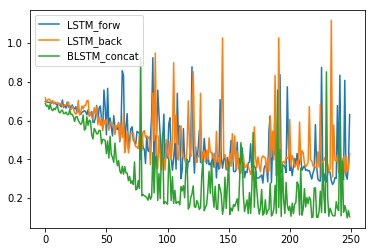

In [34]:
from matplotlib import pyplot
from pandas import DataFrame

n_timesteps = 10
results = DataFrame()

# lstm forwards
model = get_lstm_model(n_timesteps, False)
results['LSTM_forw'] = train_model(model, n_timesteps)

# lstm backwards
model = get_lstm_model(n_timesteps, True)
results['LSTM_back'] = train_model(model, n_timesteps)

# bidirectional default merge 
model = get_bi_lstm_model(n_timesteps, 'concat')
results['BLSTM_concat'] = train_model(model, n_timesteps)

# line plot of results
results.plot()
pyplot.show()

We see that LSTM forward and LSTM backward show similar log loss over 250 training epochs. This is because the order of the sequence matters, but WHICH order does not. Approaching the data from two opposite perspectives gives us **different**, but equally **effective** information about the data. 

By combining both forward and backward LSTM models to form the bidirectional LSTM Model, we see that the log loss decreases at a faster rater and generally stays lower than either of the indivudual model alone. 

# Comparing Bidirectional Merge Modes in Keras

Keras wrapper allows us to specify the merge mode, that is how the forward and backward outputs should be combined before being passed on to the next layer. The options are:

* ‘sum‘: The outputs are added together.
* ‘mul‘: The outputs are multiplied together.
* ‘concat‘: The outputs are concatenated together (the default), providing double the number of outputs to the next layer.
* ‘ave‘: The average of the outputs is taken.



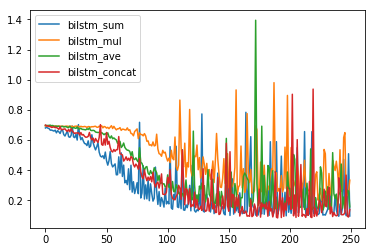

In [35]:
n_timesteps = 10
results = DataFrame()

# sum merge
model = get_bi_lstm_model(n_timesteps, 'sum')
results['bilstm_sum'] = train_model(model, n_timesteps)

# mul merge
model = get_bi_lstm_model(n_timesteps, 'mul')
results['bilstm_mul'] = train_model(model, n_timesteps)

# avg merge
model = get_bi_lstm_model(n_timesteps, 'ave')
results['bilstm_ave'] = train_model(model, n_timesteps)

# concat merge
model = get_bi_lstm_model(n_timesteps, 'concat')
results['bilstm_concat'] = train_model(model, n_timesteps)

# line plot of results
results.plot()
pyplot.show()

It looks like multiplication merger struggles to reach the same performance as the other merge modes. The average merge technique seems to take more epochs to reach the desired loss. 

In this particular example, summation and concatentation both seem to be valid merge modes. However, in most scenarios 'concat' is the preferred model merging option because it maintains the most information to make predictions. 